## Traininig the Inclusive classifier with tf.keras using data in TFRecord format

**tf.keras Inclusive classifier** This notebooks trains a dense neural network for the particle classifier using the Inclusive Classifier, using as input the full list of recunstructed particles and the High Level Features. Data is prepared in TFRecord format converting from Parquet using Apache Spark. Tensorflow data procesing uses tf.data and tf.io.

To run this notebook we used the following configuration:
* *Software stack*: TensorFlow-gpu 2.0.0-rc0
* *Platform*: CentOS 7.6, Cuda 10, Python 3.6
* GPU: Tesla P100

## Create the Keras model for the inclusive classifier

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Masking, Dense, Activation, GRU, Dropout, concatenate

In [2]:
tf.version.VERSION

'2.0.0-rc0'

In [3]:
# only needed for TensorFlow 1.x
# tf.enable_eager_execution()

In [4]:
## GRU branch
gru_input = Input(shape=(801,19), name='gru_input')
a = gru_input
a = Masking(mask_value=0.)(a)
a = GRU(units=50,activation='tanh')(a)
gruBranch = Dropout(0.2)(a)


W0826 21:30:50.711637 140367942453056 deprecation.py:323] From /local1/lucatests/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/keras/backend.py:3983: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
hlf_input = Input(shape=(14,), name='hlf_input')
b = hlf_input
hlfBranch = Dropout(0.2)(b)

In [6]:
c = concatenate([gruBranch, hlfBranch])
c = Dense(25, activation='relu')(c)
output = Dense(3, activation='softmax')(c)

In [7]:
model = Model(inputs=[gru_input, hlf_input], outputs=output)

In [8]:
## Compile model
optimizer = 'Adam'
loss = 'categorical_crossentropy'
model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"] )
    

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_input (InputLayer)          [(None, 801, 19)]    0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, 801, 19)      0           gru_input[0][0]                  
__________________________________________________________________________________________________
gru (GRU)                       (None, 50)           10650       masking[0][0]                    
__________________________________________________________________________________________________
hlf_input (InputLayer)          [(None, 14)]         0                                            
______________________________________________________________________________________________

## Load test and training data in TFRecord format, using tf.data and tf.io

In [10]:
# test dataset 
PATH = "/home/canali/Data/testUndersampled.tfrecord"
files_test_dataset = tf.data.Dataset.list_files(PATH+"/part-r*", shuffle=False)

# training dataset 
PATH = "/home/canali/Data/trainUndersampled.tfrecord"
files_train_dataset = tf.data.Dataset.list_files(PATH+"/part-r*", seed=4242)

In [11]:
# tunable
num_parallel_reads=8

test_dataset = files_test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).interleave(
    tf.data.TFRecordDataset, 
    cycle_length=num_parallel_reads,
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_dataset = files_train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).interleave(
    tf.data.TFRecordDataset, cycle_length=num_parallel_reads,
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [12]:
# Function to decode TF records into the required features and labels
def decode(serialized_example):
    deser_features = tf.io.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
          'HLF_input': tf.io.FixedLenFeature((14), tf.float32),
          'GRU_input': tf.io.FixedLenFeature((801,19), tf.float32),
          'encoded_label': tf.io.FixedLenFeature((3), tf.float32),
          })
    return((deser_features['GRU_input'], deser_features['HLF_input']), deser_features['encoded_label'])

In [13]:
# use for debug
# for record in test_dataset.take(1):
#     print(record)

In [14]:
parsed_test_dataset=test_dataset.map(decode, num_parallel_calls=tf.data.experimental.AUTOTUNE)
parsed_train_dataset=train_dataset.map(decode, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [15]:
# Show and example of the parsed data
#for record in parsed_test_dataset.take(1):
#    print(record)

In [16]:
# tunable
batch_size=128

train=parsed_train_dataset.batch(batch_size)
train=train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train=train.repeat()
train

<DatasetV1Adapter shapes: (((None, 801, 19), (None, 14)), (None, 3)), types: ((tf.float32, tf.float32), tf.float32)>

In [17]:
steps_per_epoch=3426083//batch_size  # there are 3426083 samples in the training dataset
steps_per_epoch

26766

In [18]:
# tunable
test_batch_size = 10240

test=parsed_test_dataset.batch(batch_size)
test=test.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test=test.repeat()

In [19]:
validation_steps=856090//test_batch_size  # there are 856090 samples in the test dataset
validation_steps

83

## Train the tf.keras model

In [20]:
# train the Keras model

# tunable
num_epochs = 12

# callbacks = [ tf.keras.callbacks.TensorBoard(log_dir='./logs') ]
callbacks = []
    
%time history = model.fit(train, steps_per_epoch=steps_per_epoch, \
                          validation_data=test, validation_steps=validation_steps, \
                          epochs=num_epochs, callbacks=callbacks, verbose=1)


Train for 26766 steps, validate for 83 steps
Epoch 1/12
26766/26766 [==============================] - 1441s 54ms/step - loss: 0.2413 - accuracy: 0.9104 - val_loss: 0.1620 - val_accuracy: 0.9411
Epoch 2/12
26766/26766 [==============================] - 1437s 54ms/step - loss: 0.1649 - accuracy: 0.9401 - val_loss: 0.1363 - val_accuracy: 0.9515
Epoch 3/12
26766/26766 [==============================] - 1438s 54ms/step - loss: 0.1447 - accuracy: 0.9479 - val_loss: 0.1202 - val_accuracy: 0.9567
Epoch 4/12
26766/26766 [==============================] - 1439s 54ms/step - loss: 0.1360 - accuracy: 0.9512 - val_loss: 0.1166 - val_accuracy: 0.9560
Epoch 5/12
26766/26766 [==============================] - 1438s 54ms/step - loss: 0.1312 - accuracy: 0.9531 - val_loss: 0.1102 - val_accuracy: 0.9603
Epoch 6/12
26766/26766 [==============================] - 1437s 54ms/step - loss: 0.1280 - accuracy: 0.9542 - val_loss: 0.1130 - val_accuracy: 0.9594
Epoch 7/12
26766/26766 [==============================]

In [21]:
PATH="./"
model.save(PATH + "mymodel" + ".h5", save_format='h5')

In [22]:
# TF 2.0
tf.keras.models.save_model(model, PATH+"mymodel" + ".tf", save_format='tf')

W0827 02:18:46.481957 140367942453056 deprecation.py:506] From /local1/lucatests/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1781: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Performance metrics

<IPython.core.display.Javascript object>


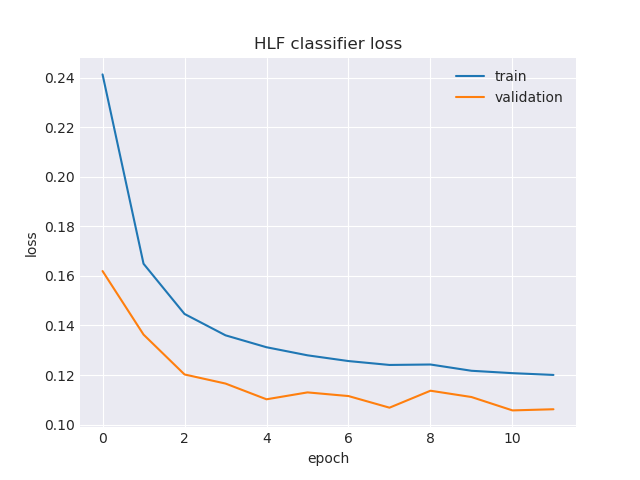

In [35]:
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
# Graph with loss vs. epoch

plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title("HLF classifier loss")
plt.show()

<IPython.core.display.Javascript object>


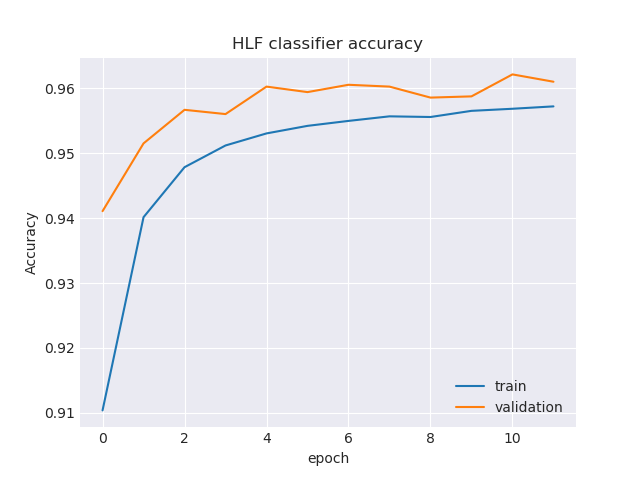

In [36]:
# Graph with accuracy vs. epoch
%matplotlib notebook
plt.figure()
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title("HLF classifier accuracy")
plt.show()

## Confusion Matrix

In [25]:
# model = tf.keras.models.load_model("./mymodel.tf")

In [26]:
%time model.evaluate(test, steps=validation_steps)

83/83 [==============================] - 2s 21ms/step - loss: 0.1062 - accuracy: 0.9610
CPU times: user 3.87 s, sys: 718 ms, total: 4.59 s
Wall time: 1.8 s


[0.10621545584984572, 0.9610316]

In [27]:
%time y_pred = model.predict(test, steps=validation_steps)
num_entries=y_pred[:,0].size

CPU times: user 4.81 s, sys: 798 ms, total: 5.61 s
Wall time: 2.86 s


In [28]:
%time y_test_all = [labels.numpy() for features,labels in parsed_test_dataset.__iter__()]

CPU times: user 5min 4s, sys: 54.9 s, total: 5min 59s
Wall time: 2min 32s


In [29]:
y_true = np.stack(y_test_all[:num_entries])

In [30]:
from sklearn.metrics import accuracy_score

print('Accuracy of the classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the classifier: 0.9610


<IPython.core.display.Javascript object>


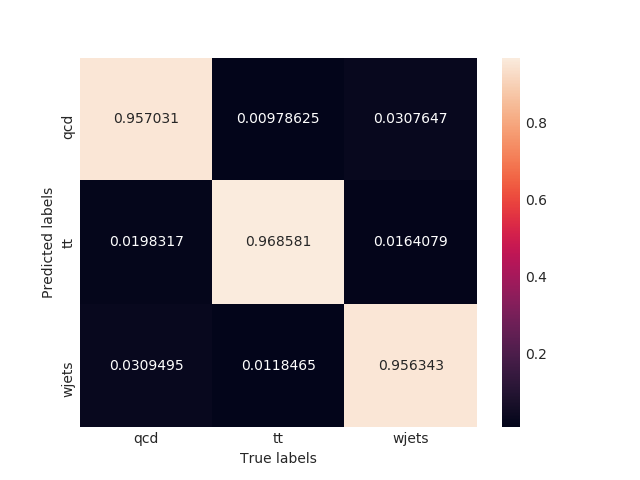

In [37]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(np.float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## ROC and AUC

In [32]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [33]:
# Dictionary containign ROC-AUC for the three classes 
roc_auc

{0: 0.9959550824081689, 1: 0.9977416116252791, 2: 0.9959030346538558}

<IPython.core.display.Javascript object>


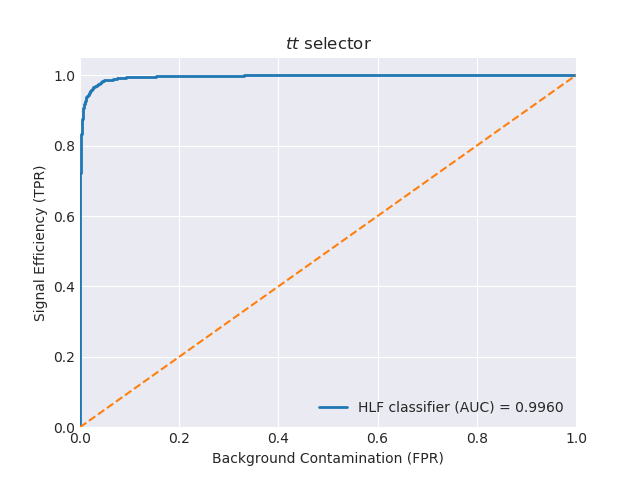

In [34]:
%matplotlib notebook

# Plot roc curve 
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')


plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, 
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()